In [13]:
import os, sys
try:
    import torch
except Exception:
    pass
DATA_ROOT = r"C:\Users\l8531\Desktop\90051\Animals_with_Attributes2"
SKIP_LEGACY_LOAD = True


In [14]:
try:
    SKIP_LEGACY_LOAD
except NameError:
    SKIP_LEGACY_LOAD = True
if SKIP_LEGACY_LOAD:
    print("Skip legacy loader cell: using the new modular pipeline below.")
else:
    import os, torch
    feats_pt = os.path.join(DATA_ROOT, "test_feats.pt")
    #saving and reloading
    ckpt = torch.load(feats_pt, map_location="cpu")
    X_test, y= ckpt["X_test"], ckpt["y"]

Skip legacy loader cell: using the new modular pipeline below.


In [15]:
try:
    SKIP_LEGACY_LOAD
except NameError:
    SKIP_LEGACY_LOAD = True
if SKIP_LEGACY_LOAD:
    print("Skip legacy loader cell: using the new modular pipeline below.")
else:
    import os, torch
    feats_pt = os.path.join(DATA_ROOT, "train_feats.pt")
    ckpt = torch.load(feats_pt, map_location="cpu")
    X_train, y = ckpt["X_train"], ckpt["y"]

Skip legacy loader cell: using the new modular pipeline below.


In [16]:
#for the requirements that using function to calculate accuracy score and confusion matrix 

In [17]:
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as tvm
import numpy as np
import torchvision.models as models
from torchvision.models import ResNet50_Weights 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
from PIL import Image
# open the file
#/Users/zhang/Desktop/slides/COMP90051/groupwork
# img = Image.open("/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages/antelope/antelope_10003.jpg")  
img = Image.open("C:\\Users\\l8531\\Desktop\\90051\\Animals_with_Attributes2/JPEGImages/antelope/antelope_10003.jpg")  
width, height = img.size
print(f"picture width: {width}, and height: {height}")

picture width: 1024, and height: 681


In [19]:
#preprocessing: to get better results, we use GaussianNoise, rotation randomly within 20 and change light
#add GaussianNoise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'
#consider using resnet to preprocessing and making feature consturction
#we need change the oringinal picture into fitful size/standard        
IMG = 224
tfm = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.RandomRotation(degrees=20),           # random rotation（±20°）
    transforms.ColorJitter(brightness=0.5),          # change color/light (0.5~1.5)
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),         # Noise
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [20]:
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import has_file_allowed_extension, IMG_EXTENSIONS

def is_ok(p):
    b = os.path.basename(p)
    return (not b.startswith(".")) and has_file_allowed_extension(p, IMG_EXTENSIONS)

train = ImageFolder( 
    # "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages",
    "C:\\Users\\l8531\\Desktop\\90051\\Animals_with_Attributes2/JPEGImages",
     transform=tfm, is_valid_file=is_ok)
train_loader = DataLoader(train, batch_size=64, shuffle=False, num_workers=0)





In [21]:
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import has_file_allowed_extension, IMG_EXTENSIONS

def is_ok(p):
    b = os.path.basename(p)
    return (not b.startswith(".")) and has_file_allowed_extension(p, IMG_EXTENSIONS)

train = ImageFolder( 
    r"C:\Users\l8531\Desktop\90051\Animals_with_Attributes2\JPEGImages",
     transform=tfm, is_valid_file=is_ok)
train_loader = DataLoader(train, batch_size=64, shuffle=False, num_workers=0)


In [22]:
#using resnet method to extract features, 
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Identity()     
resnet = resnet.to(device)
resnet.eval();

In [23]:
# at first using this code, get 2 bad files, then we decide to delete them directly
from PIL import Image
import os

# root_dir = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages"
root_dir = "C:\\Users\\l8531\\Desktop\\90051\\Animals_with_Attributes2/JPEGImages"
bad_files = []

for dirpath, _, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        try:
            img = Image.open(file_path)
            img.load()  
        except Exception:
            bad_files.append(file_path)

print(f"Images failed to load: {len(bad_files)}")


Images failed to load: 0


In [27]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

all_feats, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(train_loader, desc="Extracting features"):
        try:
            feats = resnet(imgs.to(device))      # [batch, 2048]
            all_feats.append(feats.cpu())
            all_labels.append(labels)
        except Exception:
            continue





Extracting features: 100%|██████████| 584/584 [14:32<00:00,  1.49s/it]


In [28]:
# === 6. Concatenate all feature tensors ===
X_train = torch.cat(all_feats, dim=0)   # [N, 2048]
y = torch.cat(all_labels, dim=0)  # [N]

print("Feature tensor shape:", X_train.shape)
print("Number of labels:", len(y))

Feature tensor shape: torch.Size([37322, 2048])
Number of labels: 37322


In [29]:
# we need to reload the dataset to get the test_set without preprocessing(rotation, gaussian noise, and light changes)
tfm_test = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
#loading the data
# test = datasets.ImageFolder("/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages", 
test = datasets.ImageFolder("C:\\Users\\l8531\\Desktop\\90051\\Animals_with_Attributes2/JPEGImages", 
                            transform=tfm_test, 
                            is_valid_file=lambda x: not x.startswith('.') and x.lower().endswith(('.jpg', '.jpeg', '.png'))
                           )
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)

In [30]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

all_feats1, all_labels1 = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Extracting features"):
        try:
            feats1 = resnet(imgs.to(device))      # [batch, 2048]
            all_feats1.append(feats1.cpu())
            all_labels1.append(labels)
        except Exception:
            continue

Extracting features: 100%|██████████| 584/584 [02:54<00:00,  3.35it/s]


In [31]:
# === 6. Concatenate all feature tensors ===
X_test = torch.cat(all_feats1, dim=0)   # [N, 2048]
y = torch.cat(all_labels1, dim=0)  # [N]

print("Feature tensor shape:", X_train.shape)
print("Number of labels:", len(y))

Feature tensor shape: torch.Size([37322, 2048])
Number of labels: 37322


In [32]:
X_test_parts, y_parts = [], []

for i in range(0, 50, 5):  
    #for k = 10, we divide test set into 10 parts, and each parts have 5 unseen categories
    mask = (y >= i) & (y < i + 5)
    X_test_parts.append(X_test[mask])
    y_parts.append(y[mask])

(X_test_1, X_test_2, X_test_3, X_test_4, X_test_5,
 X_test_6, X_test_7, X_test_8, X_test_9, X_test_10) = X_test_parts

(y_test_1, y_test_2, y_test_3, y_test_4, y_test_5,
 y_test_6, y_test_7, y_test_8, y_test_9, y_test_10) = y_parts
# check
for i, x in enumerate(X_test_parts, 1):
    print(f"X_test_{i}.shape = {x.shape}, y range = {y_parts[i-1].min().item()}–{y_parts[i-1].max().item()}")



X_test_1.shape = torch.Size([2426, 2048]), y range = 0–4
X_test_2.shape = torch.Size([4556, 2048]), y range = 5–9
X_test_3.shape = torch.Size([4541, 2048]), y range = 10–14
X_test_4.shape = torch.Size([4833, 2048]), y range = 15–19
X_test_5.shape = torch.Size([4108, 2048]), y range = 20–24
X_test_6.shape = torch.Size([2728, 2048]), y range = 25–29
X_test_7.shape = torch.Size([3814, 2048]), y range = 30–34
X_test_8.shape = torch.Size([3594, 2048]), y range = 35–39
X_test_9.shape = torch.Size([3599, 2048]), y range = 40–44
X_test_10.shape = torch.Size([3123, 2048]), y range = 45–49


In [33]:
import torch

X_train_parts, y_train_parts = [], []

for i in range(0, 50, 5):
    # same process but need change mask to proof unseen for train sets
    mask = (y < i) | (y >= i + 5)
    X_train_parts.append(X_train[mask])
    y_train_parts.append(y[mask])


(X_train_1, X_train_2, X_train_3, X_train_4, X_train_5,
 X_train_6, X_train_7, X_train_8, X_train_9, X_train_10) = X_train_parts

(y_train_1, y_train_2, y_train_3, y_train_4, y_train_5,
 y_train_6, y_train_7, y_train_8, y_train_9, y_train_10) = y_train_parts

# === check each train split's class distribution ===
for i in range(10):
    y_i = y_train_parts[i]
    uniq, counts = torch.unique(y_i, return_counts=True)
    uniq, counts = uniq.tolist(), counts.tolist()
    
    print(f"\nX_train_{i+1}.shape = {X_train_parts[i].shape}")
    print("distribution（class: count）:")
    for j in range(0, len(uniq), 10):
        line = ", ".join(f"{c}:{n}" for c, n in zip(uniq[j:j+10], counts[j:j+10]))
        print("   " + line)




X_train_1.shape = torch.Size([34896, 2048])
distribution（class: count）:
   5:895, 6:567, 7:728, 8:1028, 9:1338, 10:549, 11:1344, 12:946, 13:1038, 14:664
   15:1033, 16:874, 17:1202, 18:872, 19:852, 20:779, 21:684, 22:1645, 23:709, 24:291
   25:720, 26:1019, 27:100, 28:704, 29:185, 30:758, 31:728, 32:747, 33:713, 34:868
   35:1088, 36:512, 37:310, 38:696, 39:988, 40:1420, 41:500, 42:188, 43:291, 44:1200
   45:877, 46:215, 47:272, 48:589, 49:1170

X_train_2.shape = torch.Size([32766, 2048])
distribution（class: count）:
   0:1046, 1:383, 2:193, 3:174, 4:630, 10:549, 11:1344, 12:946, 13:1038, 14:664
   15:1033, 16:874, 17:1202, 18:872, 19:852, 20:779, 21:684, 22:1645, 23:709, 24:291
   25:720, 26:1019, 27:100, 28:704, 29:185, 30:758, 31:728, 32:747, 33:713, 34:868
   35:1088, 36:512, 37:310, 38:696, 39:988, 40:1420, 41:500, 42:188, 43:291, 44:1200
   45:877, 46:215, 47:272, 48:589, 49:1170

X_train_3.shape = torch.Size([32781, 2048])
distribution（class: count）:
   0:1046, 1:383, 2:193, 3:1

In [34]:
import re
import os
import pandas as pd
from torchvision import datasets

# IMG_ROOT = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages"
IMG_ROOT = "C:\\Users\\l8531\\Desktop\\90051\\Animals_with_Attributes2/JPEGImages"
# TXT_ROOT = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/licenses"
TXT_ROOT = "C:\\Users\\l8531\\Desktop\\90051\\Animals_with_Attributes2/licenses"


class_to_idx = datasets.ImageFolder(IMG_ROOT).class_to_idx  # {'antelope':0, ...}
idx_to_class = {v: k for k, v in class_to_idx.items()}


def read_title_and_desc_clean(p):
    title, desc = "", ""
    clean = lambda s: re.sub(r'[\+\-\|\_]+', '', s).strip()
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        lines = [line.strip() for line in f if line.strip()]

    for i, line in enumerate(lines):
        U = line.upper()
        if "TITLE" in U and i + 1 < len(lines):
            title = clean(lines[i + 1])
        if "DESCRIPTION" in U:
            buf = []
            for j in range(i + 1, len(lines)):
                if any(k in lines[j].upper() for k in ["TITLE","INFO","TAGS","PHOTOGRAPHER","LICENSE"]):
                    break
                buf.append(clean(lines[j]))
            desc = " ".join(buf).strip()
            break
    title = re.sub(r"<.*?>", "", title)
    desc  = re.sub(r"<.*?>", "", desc)
    return title, desc


rows = []
for cls in sorted(os.listdir(TXT_ROOT)):
    cls_dir = os.path.join(TXT_ROOT, cls)
    if not os.path.isdir(cls_dir):
        continue
    pieces = []
    for fname in sorted(os.listdir(cls_dir)):
        if fname.endswith(".txt"):
            t, d = read_title_and_desc_clean(os.path.join(cls_dir, fname))
            text = " ".join([t, d]).strip()
            if text:
                pieces.append(text)
    merged = " ".join(pieces)             
    rows.append({"class": cls, "text": merged, "n_txt": len(pieces)})


df = pd.DataFrame(rows)
df["label"] = df["class"].map(class_to_idx)
df = df.sort_values("label").reset_index(drop=True)
print("row number:", len(df))
print(df[["label","class","n_txt"]].head())


row number: 50
   label       class  n_txt
0      0    antelope   1046
1      1         bat    178
2      2      beaver    147
3      3  blue+whale    174
4      4      bobcat    627


In [35]:
#check
# txt_path = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/licenses/antelope/antelope_10021.txt"
txt_path = "C:\\Users\\l8531\\Desktop\\90051\\Animals_with_Attributes2/licenses/antelope/antelope_10021.txt"
title, desc = read_title_and_desc_clean(txt_path)
print("TITLE:", title)
print("DESCRIPTION:", desc[:200], "...")

TITLE: 
DESCRIPTION: You are free to use this photo  (including commercial use) under attribution to the author. If being used online please add a link to ujora.de Dieses Foto darf unter Angabe des Autors frei verwendet w ...


In [36]:
df.head()

,class,text,n_txt,label
0,antelope,"\And God said, Let the earth bring forth the l...",1046,0
1,bat,Found below the power lines at Hamilton Beach....,178,1
2,beaver,the local beavers on Christmas day 2007 (no de...,147,2
3,blue+whale,(no description) Free Fall breaching. (no desc...,174,3
4,bobcat,"One of the cubs walking in the enclosure, unde...",627,4


In [37]:
# 0) installing
# pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import torch, numpy as np
import pandas as pd

# 1) model choice
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2" )  # only english
# model = SentenceTransformer("BAAI/bge-small-zh-v1.5")                    # multi language

# 2) get text
texts = df["text"].fillna("").astype(str).tolist()
labels = df["label"].to_numpy()

# 3) embedding
emb = model.encode(
    texts,
    batch_size=64,
    convert_to_tensor=True,
    normalize_embeddings=True,   
    show_progress_bar=True
)   # shape: [N, D]，

print(emb.shape, emb.dtype)    


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

torch.Size([50, 768]) torch.float32


In [38]:
#machine learning
#ridge+mlp+F-CL

In [39]:
print(emb.shape, #50类语义集（从txt---Sentence-BERT)
X_train_1.shape ,#训练集（从图像集中加上噪声/旋转等----resnet，类别是5-49）
X_test_1.shape, # 测试集（未增强处理 原始数据集--- resent， 类别是0-4）
y_train_1.shape ,#（X_train_1对应的 y）
y_test_1.shape) #(X_test_1对应的y)

torch.Size([50, 768]) torch.Size([34896, 2048]) torch.Size([2426, 2048]) torch.Size([34896]) torch.Size([2426])


In [40]:
import torch
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
# X_train_1:[Ntr,2048], y_train_1:[Ntr]
# X_test_1 :[Nte,2048], y_test_1 :[Nte]
# emb      :[50, 768]   

# ----- preprocessing -----
Xtr = X_train_1.float().to(device)
Xte = X_test_1.float().to(device)
ytr = y_train_1.long().to(device)
yte = y_test_1.long().cpu().numpy()

Xtr = Xtr / (Xtr.norm(dim=1, keepdim=True) + 1e-12)
Xte = Xte / (Xte.norm(dim=1, keepdim=True) + 1e-12)

E = emb.float().to(device)
E = E / (E.norm(dim=1, keepdim=True) + 1e-12)    


Ytr = E[ytr]                                     
lam = 1.0                                        

XtX = Xtr.T @ Xtr                                 # [2048,2048]
XtY = Xtr.T @ Ytr                                 # [2048,768]
d = XtX.size(0)
W = torch.linalg.solve(XtX + lam * torch.eye(d, device=device), XtY)  # [2048,768]


with torch.no_grad():
    Z = Xte @ W                                   # [Nte,768]
    Z = Z / (Z.norm(dim=1, keepdim=True) + 1e-12)

    unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
    P = E[unseen_ids]                          
    sim = Z @ P.T                                  
    pred_ix = sim.argmax(dim=1).cpu().numpy()      # 0..U-1
    y_pred = [unseen_ids[j] for j in pred_ix]





In [41]:
import torch, numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- tensors from your env ----
X_all = X_train_1.float().to(device)      # [Ntr,2048]
y_all = y_train_1.long().to(device)       # [Ntr]
E_all = emb.float().to(device)            # [50,768]

# ---- fixed L2 normalization (keep as in your pipeline) ----
def l2norm(X): return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def fit_ridge(Xtr, Ytr, lam):
    d = Xtr.size(1)
    XtX = Xtr.T @ Xtr
    XtY = Xtr.T @ Ytr
    I = torch.eye(d, device=Xtr.device)
    return torch.linalg.solve(XtX + lam * I, XtY)  # W:[2048,768]

@torch.inference_mode()
def eval_split(Xtr, ytr, Xva, yva, lam, E):
    Xtr = l2norm(Xtr);  Xva = l2norm(Xva)
    Ytr = E[ytr]                                    # [Ntr,768]
    W = fit_ridge(Xtr, Ytr, lam)

    Z = l2norm(Xva @ W)                             
    va_classes = torch.unique(yva).tolist(); va_classes.sort()
    P = l2norm(E[va_classes])
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([va_classes[j] for j in pred_ix], dtype=np.int64)
    acc = float((y_pred == yva.cpu().numpy()).mean())
    return acc, W

# ---- build 3 class folds: 45 classes -> 15/15/15 by order ----
seen_classes = torch.unique(y_all).cpu().tolist(); seen_classes.sort()
assert len(seen_classes) == 45
folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]

def split_by_class(X, y, val_classes):
    val_set = set(val_classes)
    mask_va = torch.tensor([int(int(t.item()) in val_set) for t in y], device=y.device, dtype=torch.bool)
    mask_tr = ~mask_va
    return X[mask_tr], y[mask_tr], X[mask_va], y[mask_va]

# ---- hyperparameter grid (only lam) ----
lam_grid = [0.1, 1.0, 10.0]   # original = 1.0

best_score, best_lam = -1.0, None
for lam in lam_grid:
    fold_accs = []
    for val_classes in folds:
        Xtr_f, ytr_f, Xva_f, yva_f = split_by_class(X_all, y_all, val_classes)
        acc, _ = eval_split(Xtr_f, ytr_f, Xva_f, yva_f, lam, E_all)
        fold_accs.append(acc)
    mean_acc = float(np.mean(fold_accs))
    if mean_acc > best_score:
        best_score, best_lam = mean_acc, lam
print(f"[CV by class] best mean acc = {best_score:.4f}, best lam = {best_lam}")


results = {}                  # {lam: {"fold_accs":[...], "mean":float, "max":float}}

for lam in lam_grid:
    fold_accs = []
    for val_classes in folds:  
        Xtr_f, ytr_f, Xva_f, yva_f = split_by_class(X_all, y_all, val_classes)
        acc_f, _ = eval_split(Xtr_f, ytr_f, Xva_f, yva_f, lam, E_all)
        fold_accs.append(acc_f)

    mean_acc = float(np.mean(fold_accs))
    max_acc  = float(np.max(fold_accs))
    results[lam] = {"fold_accs": fold_accs, "mean": mean_acc, "max": max_acc}


    print(f"lam={lam:>5}: folds={['%.4f'%a for a in fold_accs]}  "
          f"mean={mean_acc:.4f}  best_acc_for_this_lam={max_acc:.4f}")

    if mean_acc > best_score:
        best_score, best_lam = mean_acc, lam

print(f"\n[CV summary] best mean acc = {best_score:.4f}, best lam = {best_lam}")


print("\nPer-λ summary (sorted by mean):")
for lam, rec in sorted(results.items(), key=lambda kv: kv[1]["mean"], reverse=True):
    print(f"lam={lam:>5}  mean={rec['mean']:.4f}  max={rec['max']:.4f}  folds={['%.4f'%a for a in rec['fold_accs']]}")


# ---- retrain on all 45 seen classes with best lam ----
Xtr_final = l2norm(X_all)
Ytr_final = E_all[y_all]
W = fit_ridge(Xtr_final, Ytr_final, best_lam)

# ---- test (same protocol) ----
with torch.inference_mode():
    Xte = l2norm(X_test_1.float().to(device))
    Z = l2norm(Xte @ W)
    unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
    P = l2norm(E_all[unseen_ids])
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([unseen_ids[j] for j in pred_ix], dtype=np.int64)

acc = accuracy_score(y_test_1.cpu().numpy(), y_pred)
cm  = confusion_matrix(y_test_1.cpu().numpy(), y_pred, labels=unseen_ids)
print("Test Acc:", acc)
print("Confusion matrix shape:", cm.shape)


[CV by class] best mean acc = 0.3060, best lam = 10.0
lam=  0.1: folds=['0.2205', '0.3432', '0.3056']  mean=0.2898  best_acc_for_this_lam=0.3432
lam=  1.0: folds=['0.2266', '0.3396', '0.3259']  mean=0.2974  best_acc_for_this_lam=0.3396
lam= 10.0: folds=['0.2426', '0.3319', '0.3434']  mean=0.3060  best_acc_for_this_lam=0.3434

[CV summary] best mean acc = 0.3060, best lam = 10.0

Per-λ summary (sorted by mean):
lam= 10.0  mean=0.3060  max=0.3434  folds=['0.2426', '0.3319', '0.3434']
lam=  1.0  mean=0.2974  max=0.3396  folds=['0.2266', '0.3396', '0.3259']
lam=  0.1  mean=0.2898  max=0.3432  folds=['0.2205', '0.3432', '0.3056']
Test Acc: 0.42126957955482275
Confusion matrix shape: (5, 5)


### ridge k=10 cross validation for train_test result

In [42]:
import torch, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_recall_fscore_support)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def l2norm(X): 
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def fit_ridge(Xtr, Ytr, lam=10.0):
    d = Xtr.size(1)
    XtX = Xtr.T @ Xtr
    XtY = Xtr.T @ Ytr
    I  = torch.eye(d, device=Xtr.device)
    return torch.linalg.solve(XtX + lam * I, XtY)   # [feat_dim, emb_dim]

@torch.inference_mode()
def predict_with_prototypes(X, W, E_mat, class_ids):
    """返回 y_pred（这些 class_ids 中的预测ID）、以及 Z= X@W 的单位化嵌入"""
    Z = l2norm(X @ W)                          # [N, emb]
    P = l2norm(E_mat[class_ids])               # [U, emb]
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()  # 0..U-1
    y_pred  = np.array([class_ids[j] for j in pred_ix], dtype=np.int64)
    return y_pred, Z

def classification_report_all(y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', labels=labels, zero_division=0)
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', labels=labels, zero_division=0)
    p_w, r_w, f_w, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', labels=labels, zero_division=0)
    return {
        'accuracy': acc,
        'precision_micro': p_micro, 'recall_micro': r_micro, 'f1_micro': f_micro,
        'precision_macro': p_macro, 'recall_macro': r_macro, 'f1_macro': f_macro,
        'precision_weighted': p_w, 'recall_weighted': r_w, 'f1_weighted': f_w,
    }

def embedding_errors(Z, y_true, E_mat):

    T = l2norm(E_mat[torch.as_tensor(y_true, device=Z.device)])
    diff = (Z - T).detach().cpu().numpy()
    mse = float((diff**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diff).mean())
    return {'rmse': rmse, 'mae': mae}

def plot_conf_mat(cm, class_ids, title='Confusion Matrix', save_path=None):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('True')
    ticks = np.arange(len(class_ids))
    plt.xticks(ticks, class_ids, rotation=90)
    plt.yticks(ticks, class_ids)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

def learning_curve_ridge(Xtr, ytr, Xte, yte, E_mat, lam=10.0,
                         train_fracs=(0.1, 0.3, 0.5, 0.7, 1.0),
                         title='Learning Curve', save_path=None):


    seen_ids = sorted(set(ytr.cpu().numpy().tolist()))
    unseen_ids = sorted(set(yte.cpu().numpy().tolist()))

    Ntr = Xtr.size(0)
    order = torch.randperm(Ntr, device=Xtr.device)  

    train_accs, val_accs = [], []
    for f in train_fracs:
        k = max(1, int(Ntr * f))
        idx = order[:k]
        Xtr_k, ytr_k = Xtr[idx], ytr[idx]

        Ytr_k = E_mat[ytr_k]
        W = fit_ridge(l2norm(Xtr_k), Ytr_k, lam=lam)

        y_tr_pred, _ = predict_with_prototypes(l2norm(Xtr_k), W, E_mat, seen_ids)
        train_acc = accuracy_score(ytr_k.cpu().numpy(), y_tr_pred)

        y_val_pred, _ = predict_with_prototypes(l2norm(Xte), W, E_mat, unseen_ids)
        val_acc = accuracy_score(yte.cpu().numpy(), y_val_pred)

        train_accs.append(train_acc); val_accs.append(val_acc)


    xs = [int(Ntr*f) for f in train_fracs]
    plt.figure()
    plt.plot(xs, train_accs, marker='o', label='Train (seen)')
    plt.plot(xs, val_accs, marker='o', label='Validation (unseen)')
    plt.xlabel('#Training Samples'); plt.ylabel('Accuracy'); plt.title(title)
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.4)
    if save_path: plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    return train_accs, val_accs



[Fold 01]  λ=10.0
Accuracy: 0.4213
Precision (micro/macro/weighted): 0.4213 0.5586 0.426
Recall    (micro/macro/weighted): 0.4213 0.5939 0.4213
F1        (micro/macro/weighted): 0.4213 0.4426 0.2967
Embedding RMSE: 0.037721  MAE: 0.029026


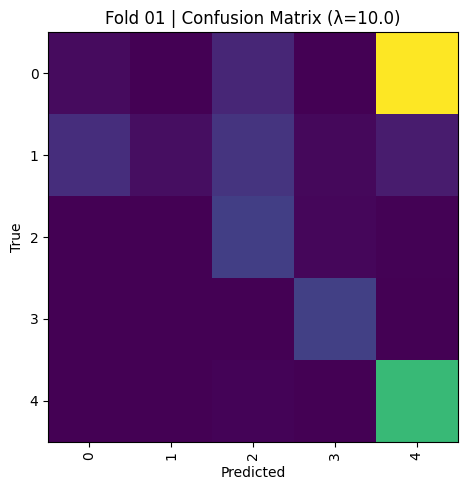

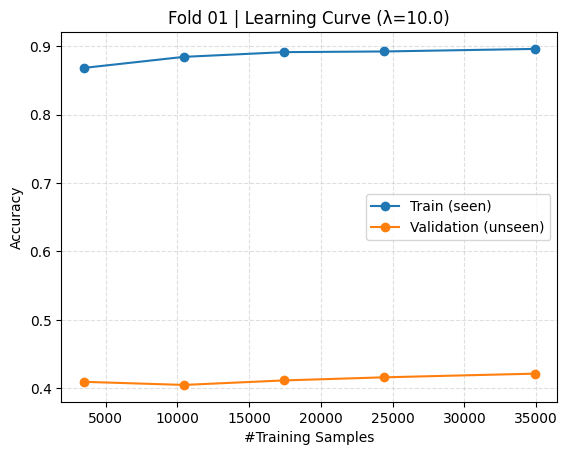


[Fold 02]  λ=10.0
Accuracy: 0.696
Precision (micro/macro/weighted): 0.696 0.7543 0.7784
Recall    (micro/macro/weighted): 0.696 0.6739 0.696
F1        (micro/macro/weighted): 0.696 0.6781 0.7019
Embedding RMSE: 0.031864  MAE: 0.024467


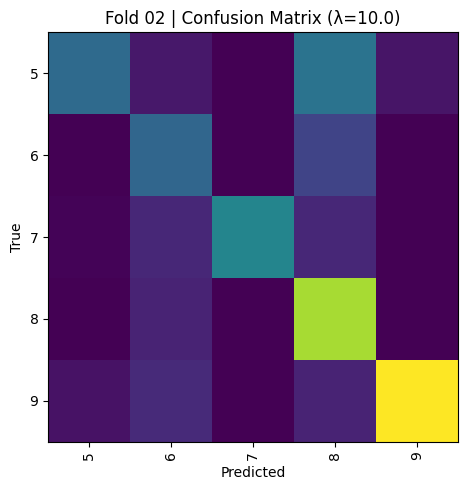

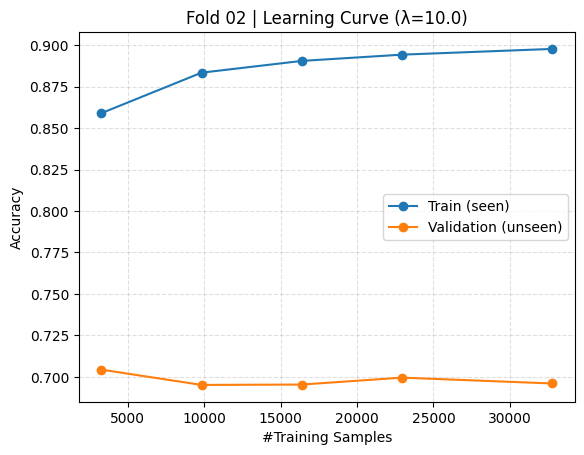


[Fold 03]  λ=10.0
Accuracy: 0.2665
Precision (micro/macro/weighted): 0.2665 0.4263 0.4018
Recall    (micro/macro/weighted): 0.2665 0.2374 0.2665
F1        (micro/macro/weighted): 0.2665 0.2428 0.2682
Embedding RMSE: 0.038526  MAE: 0.029885


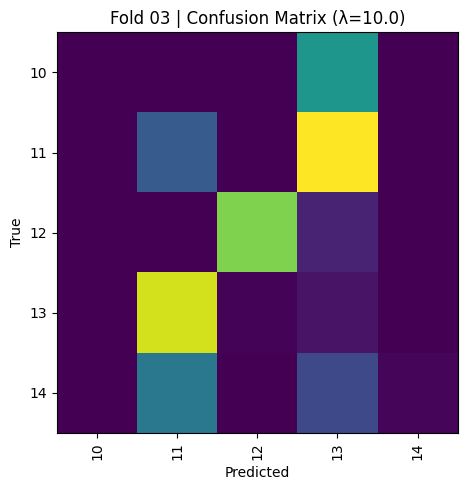

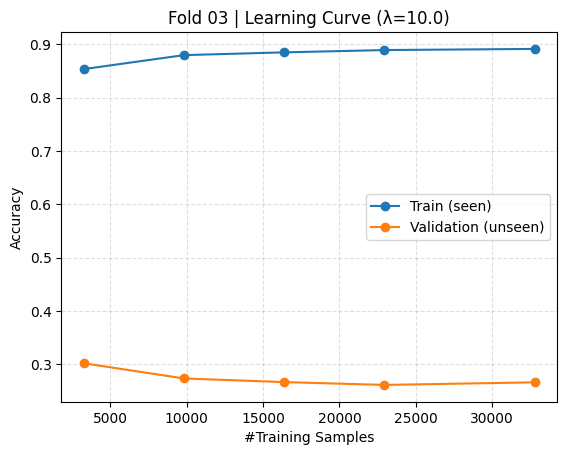


[Fold 04]  λ=10.0
Accuracy: 0.3387
Precision (micro/macro/weighted): 0.3387 0.536 0.5235
Recall    (micro/macro/weighted): 0.3387 0.3484 0.3387
F1        (micro/macro/weighted): 0.3387 0.3221 0.3215
Embedding RMSE: 0.033595  MAE: 0.025781


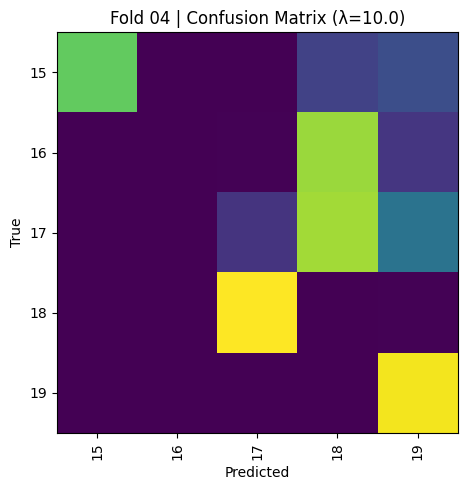

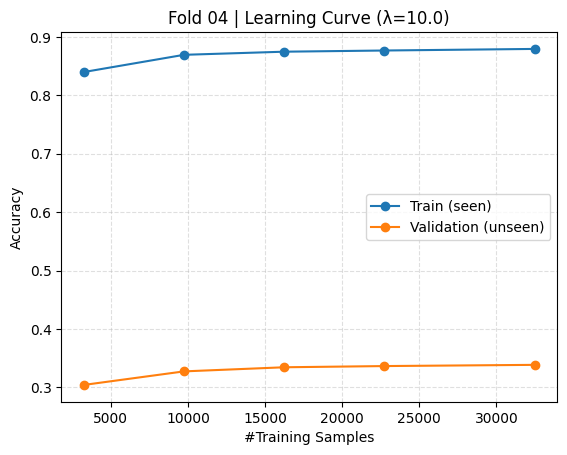


[Fold 05]  λ=10.0
Accuracy: 0.6271
Precision (micro/macro/weighted): 0.6271 0.566 0.7204
Recall    (micro/macro/weighted): 0.6271 0.4758 0.6271
F1        (micro/macro/weighted): 0.6271 0.4687 0.6307
Embedding RMSE: 0.034005  MAE: 0.026397


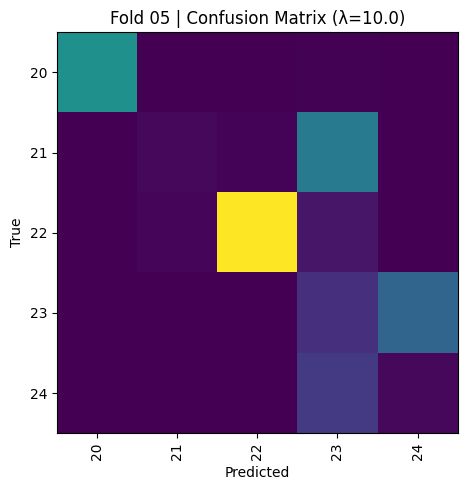

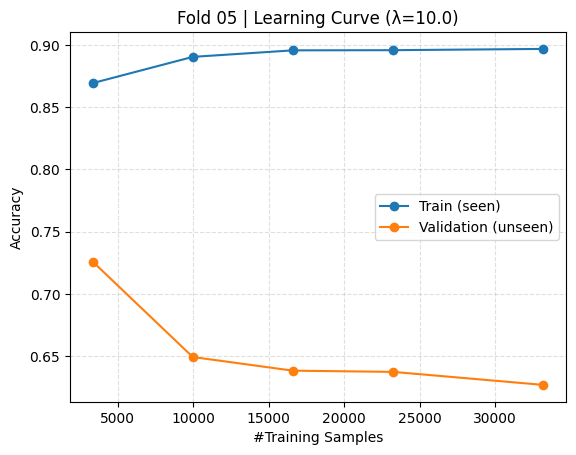


[Fold 06]  λ=10.0
Accuracy: 0.5029
Precision (micro/macro/weighted): 0.5029 0.4808 0.4703
Recall    (micro/macro/weighted): 0.5029 0.4519 0.5029
F1        (micro/macro/weighted): 0.5029 0.441 0.4707
Embedding RMSE: 0.034435  MAE: 0.026518


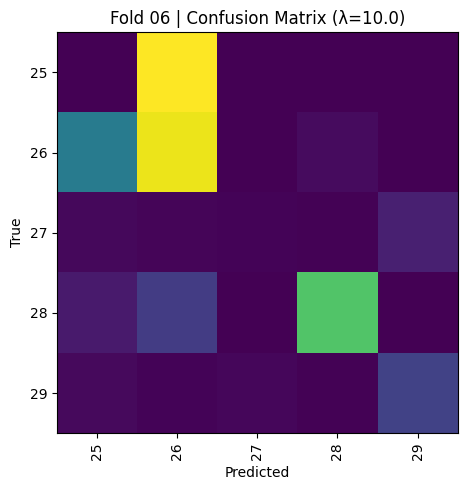

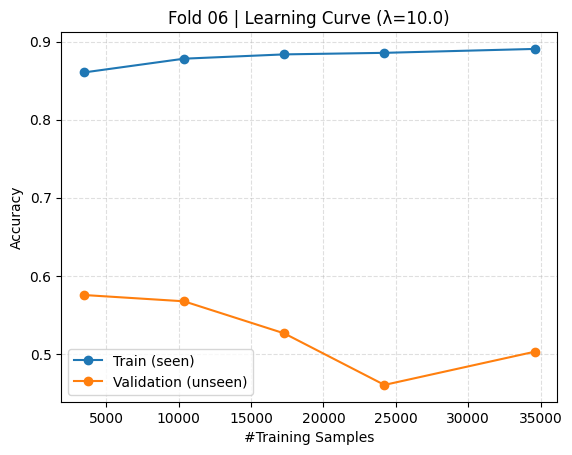


[Fold 07]  λ=10.0
Accuracy: 0.6935
Precision (micro/macro/weighted): 0.6935 0.6087 0.617
Recall    (micro/macro/weighted): 0.6935 0.6801 0.6935
F1        (micro/macro/weighted): 0.6935 0.6017 0.6125
Embedding RMSE: 0.032016  MAE: 0.024779


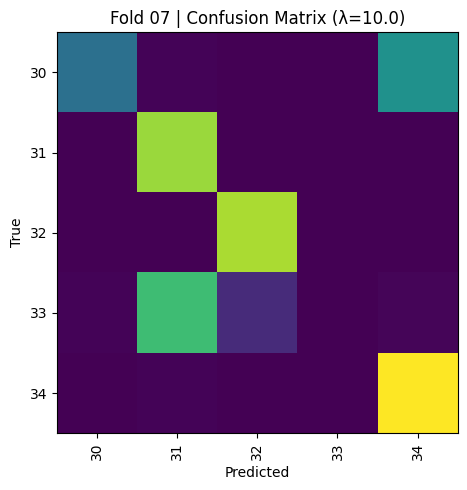

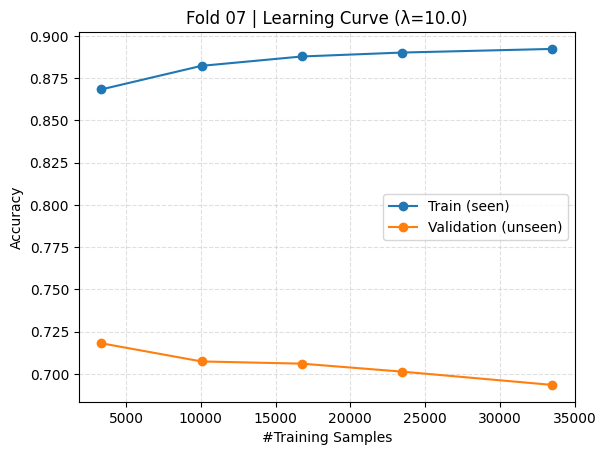


[Fold 08]  λ=10.0
Accuracy: 0.4989
Precision (micro/macro/weighted): 0.4989 0.6061 0.555
Recall    (micro/macro/weighted): 0.4989 0.5719 0.4989
F1        (micro/macro/weighted): 0.4989 0.5075 0.4593
Embedding RMSE: 0.034076  MAE: 0.026345


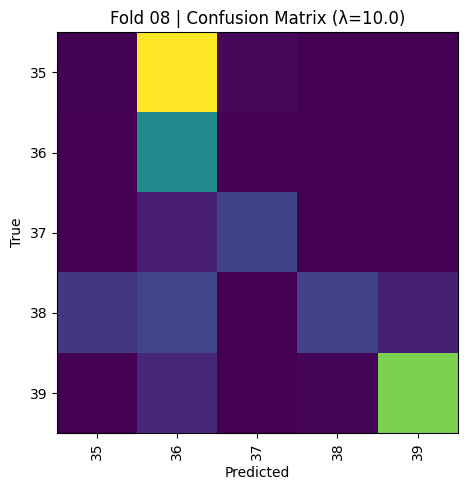

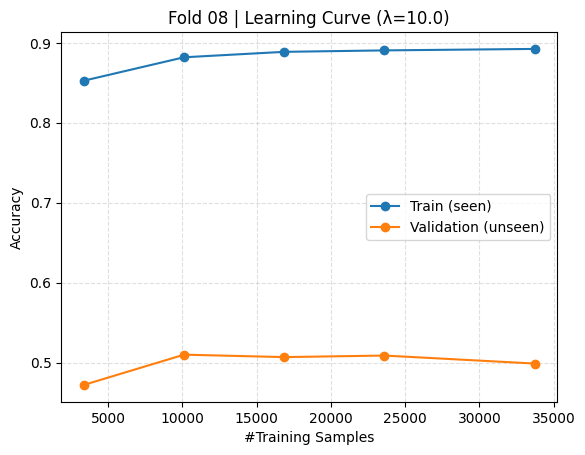


[Fold 09]  λ=10.0
Accuracy: 0.6985
Precision (micro/macro/weighted): 0.6985 0.6727 0.7782
Recall    (micro/macro/weighted): 0.6985 0.5113 0.6985
F1        (micro/macro/weighted): 0.6985 0.5468 0.7202
Embedding RMSE: 0.032277  MAE: 0.025004


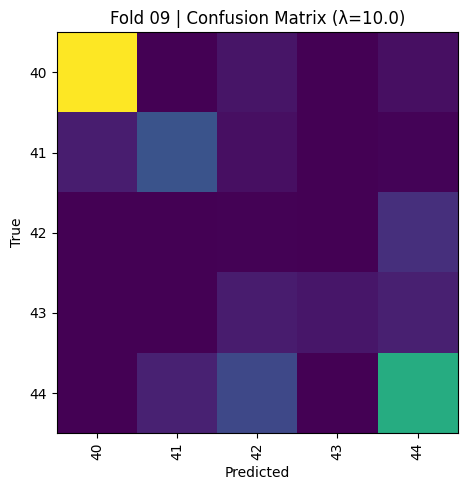

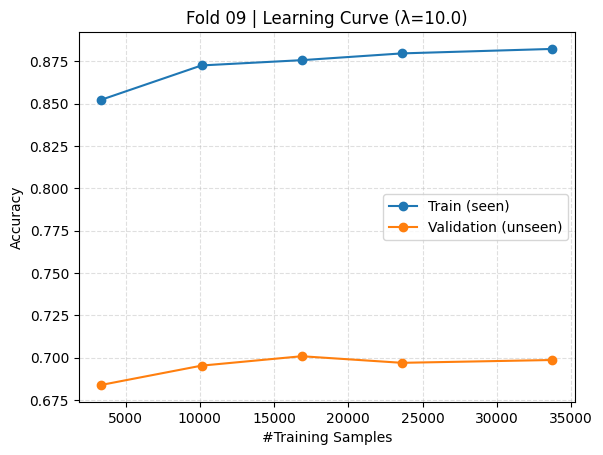


[Fold 10]  λ=10.0
Accuracy: 0.6849
Precision (micro/macro/weighted): 0.6849 0.7853 0.8548
Recall    (micro/macro/weighted): 0.6849 0.6918 0.6849
F1        (micro/macro/weighted): 0.6849 0.6058 0.6672
Embedding RMSE: 0.033892  MAE: 0.026102


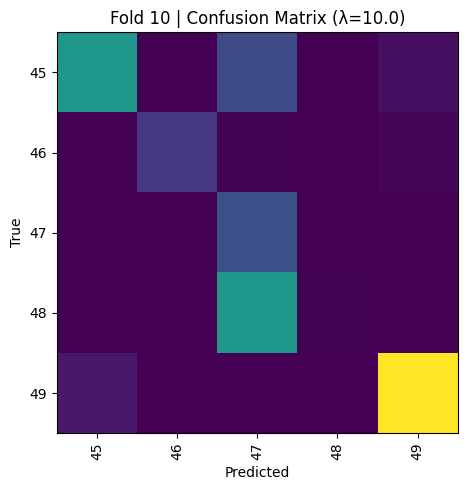

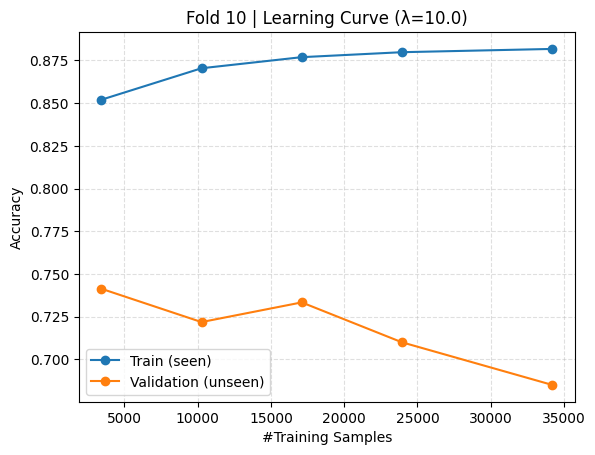


[10-fold Accuracy]  λ = 10.0
per-fold: ['0.4213', '0.6960', '0.2665', '0.3387', '0.6271', '0.5029', '0.6935', '0.4989', '0.6985', '0.6849']
mean = 0.5428   std = 0.1530


In [43]:
from sklearn.metrics import confusion_matrix

lam = 10.0
E = l2norm(emb.float().to(device))

all_acc = []

for i in range(1, 11):

    Xtr = l2norm(globals()[f"X_train_{i}"].float().to(device))
    ytr = globals()[f"y_train_{i}"].long().to(device)
    Xte = l2norm(globals()[f"X_test_{i}"].float().to(device))
    yte = globals()[f"y_test_{i}"].long().to(device)


    W = fit_ridge(Xtr, E[ytr], lam=lam)


    unseen_ids = sorted(set(yte.cpu().numpy().tolist()))
    y_pred, Z_te = predict_with_prototypes(Xte, W, E, unseen_ids)

    y_true = yte.cpu().numpy()
    all_acc.append(accuracy_score(y_true, y_pred))


    report = classification_report_all(y_true, y_pred, labels=unseen_ids)

    cm = confusion_matrix(y_true, y_pred, labels=unseen_ids)

    print(f"\n[Fold {i:02d}]  λ={lam}")
    print("Accuracy:", round(report['accuracy'], 4))
    print("Precision (micro/macro/weighted):",
          round(report['precision_micro'],4), round(report['precision_macro'],4), round(report['precision_weighted'],4))
    print("Recall    (micro/macro/weighted):",
          round(report['recall_micro'],4),    round(report['recall_macro'],4),    round(report['recall_weighted'],4))
    print("F1        (micro/macro/weighted):",
          round(report['f1_micro'],4),        round(report['f1_macro'],4),        round(report['f1_weighted'],4))


    emb_err = embedding_errors(Z_te, y_true, E)
    print("Embedding RMSE:", round(emb_err['rmse'], 6), " MAE:", round(emb_err['mae'], 6))


    plot_conf_mat(cm, class_ids=unseen_ids,
             title=f'Fold {i:02d} | Confusion Matrix (λ={lam})',
              save_path=f'confmat_fold{i:02d}.png')


    learning_curve_ridge(Xtr, ytr, Xte, yte, E, lam=lam,
                         title=f'Fold {i:02d} | Learning Curve (λ={lam})',
                          save_path=f'lc_fold{i:02d}.png')

all_acc = np.array(all_acc, dtype=float)
print("\n[10-fold Accuracy]  λ =", lam)
print("per-fold:", ["%.4f"%a for a in all_acc])
print(f"mean = {all_acc.mean():.4f}   std = {all_acc.std(ddof=0):.4f}")


## algorithm2(medium): mlp

In [44]:
#first we just using the first train_test combination to training the model
import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Xtr = X_train_1.float().to(device)
ytr = y_train_1.long().to(device)
Xte = X_test_1.float().to(device)
yte = y_test_1.long().cpu().numpy()

# ---------- normalisation----------
Xtr = Xtr / (Xtr.norm(dim=1, keepdim=True) + 1e-12)
Xte = Xte / (Xte.norm(dim=1, keepdim=True) + 1e-12)
E   = emb.float().to(device)
E   = E / (E.norm(dim=1, keepdim=True) + 1e-12)

# ---------- model ----------
class Img2Txt(nn.Module):
    def __init__(self, in_dim=2048, hid=1024, out_dim=768, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid), nn.ReLU(), nn.Dropout(p),
            nn.Linear(hid, out_dim)
        )
    def forward(self, x):
        z = self.net(x)
        return z / (z.norm(dim=1, keepdim=True) + 1e-12)  

model = Img2Txt(in_dim=Xtr.size(1), out_dim=E.size(1)).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
crit = nn.MSELoss()

# ---------- training ----------
model.train()
bs, epochs = 256, 40
for ep in range(epochs):
    idx = torch.randperm(Xtr.size(0), device=device)
    for i in range(0, Xtr.size(0), bs):
        b = idx[i:i+bs]
        pred = model(Xtr[b])          # [b, 768]
        tgt  = E[ytr[b]]              # [b, 768]
        loss = crit(pred, tgt)
        opt.zero_grad(); loss.backward(); opt.step()

# ---------- testing ----------
model.eval()
with torch.no_grad():
    protos_idx = sorted(set(y_test_1.cpu().numpy().tolist()))  
    P = E[protos_idx]                                           
    Z = model(Xte)                                            
    sim = Z @ P.T                                           
    pred_ix = sim.argmax(dim=1).cpu().numpy()                
    y_pred = [protos_idx[j] for j in pred_ix]

# ---------- result ----------
acc = accuracy_score(yte, y_pred)
cm  = confusion_matrix(yte, y_pred, labels=protos_idx)

print("Accuracy:", round(acc, 4))
print("Confusion matrix (rows=true, cols=pred):\n", cm)


Accuracy: 0.4023
Confusion matrix (rows=true, cols=pred):
 [[  8   0 689   0 349]
 [121   0  64   8 190]
 [  0   0 170  13  10]
 [  0   0   0 174   0]
 [  0   0   6   0 624]]


In [47]:
# better mlp for stop earlier and regularization
import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def l2norm(x):
    return x / (x.norm(dim=1, keepdim=True) + 1e-12)

# 确保不在原张量上原地改；同时放到 device
Xtr = l2norm(X_train_1.float().clone()).to(device)
Xte = l2norm(X_test_1.float().clone()).to(device)
E   = l2norm(emb.float().clone()).to(device)
ytr = y_train_1.long().to(device)
yte = y_test_1.long().cpu().numpy()



ds = TensorDataset(Xtr, ytr)
n_val = max(1000, int(0.1*len(ds)))
n_tr  = len(ds)-n_val
tr_ds, val_ds = random_split(ds, [n_tr, n_val], generator=torch.Generator().manual_seed(42))
tr_dl  = DataLoader(tr_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=512)

class Img2Txt(nn.Module):
    def __init__(self, in_dim=2048, out_dim=E.size(1)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(512, out_dim),
        )
    def forward(self, x):
        z = self.net(x)
        return z / (z.norm(dim=1, keepdim=True) + 1e-12)

model = Img2Txt(Xtr.size(1), E.size(1)).to(device)
opt   = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
mse   = nn.MSELoss()

def eval_seen_val():
    model.eval()
    with torch.no_grad():
        P = E.to(device)
        correct, total = 0, 0
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            z  = model(xb)
            sim = z @ P.T
            pred = sim.argmax(dim=1)
            correct += (pred==yb).sum().item()
            total   += yb.numel()
    return correct/total

best_acc, patience, wait = 0.0, 5, 0
for ep in range(30):
    model.train()
    for xb, yb in tr_dl:
        xb, yb = xb.to(device), yb.to(device)
        loss = mse(model(xb), E[yb].to(device))
        opt.zero_grad(); loss.backward(); opt.step()
    val_acc = eval_seen_val()
    if val_acc > best_acc:
        best_acc, wait = val_acc, 0
        best = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= patience: break

model.load_state_dict(best); model.eval()
with torch.no_grad():
    unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
    P = E[unseen_ids].to(device)
    Z = model(Xte.to(device))
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = [unseen_ids[j] for j in pred_ix]
acc = accuracy_score(yte, y_pred)
cm  = confusion_matrix(yte, y_pred, labels=unseen_ids)
print("MLP (reg+earlystop) acc:", round(acc,4), "\n", cm)


MLP (reg+earlystop) acc: 0.4542 
 [[ 16   0 473   0 557]
 [ 43 134 105  46  55]
 [  2   0 176   9   6]
 [  0   0   0 174   0]
 [  2   0  25   1 602]]


In [48]:
import torch, numpy as np
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------ tensors ------
X_all = X_train_1.float().to(device)      # [Ntr,2048]
y_all = y_train_1.long().to(device)       # [Ntr]
X_te  = X_test_1.float().to(device)       # [Nte,2048]
y_te  = y_test_1.long().cpu().numpy()
E     = emb.float().to(device)            # [50,768]

# ------ l2 normalize helper ------
def l2norm(X): return X / (X.norm(dim=1, keepdim=True) + 1e-12)

# ------ folds into three sets 15/15/15 ------
seen_classes = torch.unique(y_all).cpu().tolist(); seen_classes.sort()
assert len(seen_classes) == 45, f"Expect 45 seen classes, got {len(seen_classes)}"
folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]

def split_by_class(X, y, val_classes):
    vs = set(val_classes)
    mask_va = torch.tensor([int(int(t.item()) in vs) for t in y], device=y.device, dtype=torch.bool)
    mask_tr = ~mask_va
    return X[mask_tr], y[mask_tr], X[mask_va], y[mask_va]

def make_loader(X, y, bs, shuffle):
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

# ------ MLP defination------
class Img2Txt(nn.Module):
    def __init__(self, in_dim=2048, out_dim=E.size(1), hidden_dim=512, dropout_p=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x):
        z = self.net(x)
        return z / (z.norm(dim=1, keepdim=True) + 1e-12)

@torch.no_grad()
def eval_on_loader(model, dl, E_mat, val_classes):
    model.eval()
    cls = sorted(val_classes)
    P = E_mat[cls]                     
    P = P / (P.norm(dim=1, keepdim=True) + 1e-12)
    correct = total = 0
    for xb, yb in dl:
        xb = xb.to(device); yb = yb.to(device)
        sim = model(xb) @ P.T
        pred_ix = sim.argmax(dim=1).cpu().numpy()   # 0..14
        y_pred = torch.tensor([cls[j] for j in pred_ix], device=yb.device)
        correct += (y_pred == yb).sum().item()
        total   += yb.numel()
    return correct / total

def train_one_fold(Xtr, ytr, Xva, yva, dropout_p,
                   lr=1e-3, weight_decay=5e-3, patience=5, max_ep=30, bs=256):

    Xtr, Xva = l2norm(Xtr), l2norm(Xva)
    tr_dl = make_loader(Xtr, ytr, bs, shuffle=True)
    va_dl = make_loader(Xva, yva, 512, shuffle=False)

    model = Img2Txt(Xtr.size(1), E.size(1), hidden_dim=512, dropout_p=dropout_p).to(device)
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse = nn.MSELoss()

    best_acc, best_state, wait = 0.0, None, 0
    for ep in range(max_ep):
        model.train()
        for xb, yb in tr_dl:
            xb = xb.to(device); yb = yb.to(device)
            loss = mse(model(xb), E[yb])
            opt.zero_grad(); loss.backward(); opt.step()
        val_acc = eval_on_loader(model, val_dl, E, val_classes)
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
    return best_acc, best_state

p_grid = [0.0, 0.4, 0.6]   
results = {}               
best_p, best_mean, best_state_global = None, -1.0, None

for p in p_grid:
    fold_accs = []
    print(f"\n===== Dropout p = {p} =====")
    for fi, val_classes in enumerate(folds, start=1):
        Xtr_f, ytr_f, Xva_f, yva_f = split_by_class(X_all, y_all, val_classes)
        acc_f, state_f = train_one_fold(Xtr_f, ytr_f, Xva_f, yva_f, dropout_p=p)
        fold_accs.append(acc_f)
        print(f"  Fold {fi} (val classes {val_classes[0]}–{val_classes[-1]}): val-acc = {acc_f:.4f}")
    mean_acc = float(np.mean(fold_accs))
    results[p] = fold_accs
    print(f"--> Mean val-acc @ p={p}: {mean_acc:.4f}")

    if mean_acc > best_mean:
        best_mean, best_p = mean_acc, p
       
        best_state_global = state_f


print("\n===== Summary over hyperparameter p =====")
for p, accs in results.items():
    print(f"p={p}: folds={['%.4f'%a for a in accs]}  mean={np.mean(accs):.4f}")
print(f"\n[Best] dropout_p = {best_p}  mean val-acc = {best_mean:.4f}")


Xtr_full = l2norm(X_all); ytr_full = y_all
tr_dl_full = make_loader(Xtr_full, ytr_full, 256, True)

model = Img2Txt(X_all.size(1), E.size(1), hidden_dim=512, dropout_p=best_p).to(device)
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
mse = nn.MSELoss()


for ep in range(10):
    model.train()
    for xb, yb in tr_dl_full:
        xb = xb.to(device); yb = yb.to(device)
        loss = mse(model(xb), E[yb])
        opt.zero_grad(); loss.backward(); opt.step()


with torch.no_grad():
    Z = l2norm(model(l2norm(X_te)))
    unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
    P_unseen = l2norm(E[unseen_ids])
    sim = Z @ P_unseen.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([unseen_ids[j] for j in pred_ix], dtype=np.int64)

acc = accuracy_score(y_te, y_pred)
cm  = confusion_matrix(y_te, y_pred, labels=unseen_ids)
print(f"\n[MLP Test] best p={best_p}  acc={acc:.4f}")
print("Confusion matrix shape:", cm.shape)



===== Dropout p = 0.0 =====
  Fold 1 (val classes 5–19): val-acc = 0.0949
  Fold 2 (val classes 20–34): val-acc = 0.1129
  Fold 3 (val classes 35–49): val-acc = 0.1046
--> Mean val-acc @ p=0.0: 0.1041

===== Dropout p = 0.4 =====
  Fold 1 (val classes 5–19): val-acc = 0.0943
  Fold 2 (val classes 20–34): val-acc = 0.1101
  Fold 3 (val classes 35–49): val-acc = 0.1201
--> Mean val-acc @ p=0.4: 0.1081

===== Dropout p = 0.6 =====
  Fold 1 (val classes 5–19): val-acc = 0.0889
  Fold 2 (val classes 20–34): val-acc = 0.1089
  Fold 3 (val classes 35–49): val-acc = 0.1227
--> Mean val-acc @ p=0.6: 0.1068

===== Summary over hyperparameter p =====
p=0.0: folds=['0.0949', '0.1129', '0.1046']  mean=0.1041
p=0.4: folds=['0.0943', '0.1101', '0.1201']  mean=0.1081
p=0.6: folds=['0.0889', '0.1089', '0.1227']  mean=0.1068

[Best] dropout_p = 0.4  mean val-acc = 0.1081

[MLP Test] best p=0.4  acc=0.4279
Confusion matrix shape: (5, 5)


In [49]:
import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)



# X_train_1:[N_seen,2048], y_train_1:[N_seen]   （seen class 5..49）
# X_test_1 :[N_test,2048], y_test_1 :[N_test]   （unseen class 0..4）
# emb      :[50, D_txt]   
X_seen = X_train_1.float().to(device)
y_seen = y_train_1.long().to(device)
X_te   = X_test_1.float().to(device)
y_te   = y_test_1.long().cpu().numpy()
E_all  = emb.float().to(device)


def l2n(x): return x / (x.norm(dim=1, keepdim=True)+1e-12)
X_seen, X_te, E_all = l2n(X_seen), l2n(X_te), l2n(E_all)

seen_ids   = sorted(set(y_train_1.cpu().numpy().tolist()))
unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
E_seen     = E_all[seen_ids]    # [S, D_txt]
E_unseen   = E_all[unseen_ids]  # [U, D_txt]

D_txt = E_all.size(1)
D_img = X_seen.size(1)
Z_dim = 128

# ====== model defination（f-CLSWGAN：G(z, e_txt)->x_feat；D(x, e_txt)->critic + aux）======
class Generator(nn.Module):
    def __init__(self, z=Z_dim, c=D_txt, out=D_img):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z+c, 1024), nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 1024), nn.LeakyReLU(0.2, True),
            nn.Linear(1024, out),
        )
    def forward(self, z, e):
        x = torch.cat([z, e], 1)
        o = self.net(x)
        return l2n(o)

class Discriminator(nn.Module):
    def __init__(self, c=D_txt, inp=D_img, n_cls=len(seen_ids)):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Linear(inp+c, 1024), nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 512),  nn.LeakyReLU(0.2, True),
        )
        self.critic = nn.Linear(512, 1)                 # WGAN critic
        self.aux    = nn.Linear(512, n_cls)        
    def forward(self, x, e):
        h = self.feat(torch.cat([x, e], 1))
        return self.critic(h), self.aux(h)

G = Generator().to(device)
D = Discriminator().to(device)

def gp(real_x, fake_x, e_txt):
   
    b = real_x.size(0)
    eps = torch.rand(b, 1, device=device)
    inter = eps*real_x + (1-eps)*fake_x
    inter.requires_grad_(True)
    score, _ = D(inter, e_txt)
    grad = torch.autograd.grad(
        outputs=score, inputs=inter,
        grad_outputs=torch.ones_like(score),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    return ((grad.view(b, -1).norm(2, dim=1) - 1)**2).mean()

# ====== training（only in seen）======
bs = 256
epochs = 30
n_critic = 5
λ_gp = 10.0
λ_aux = 1.0
optD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
optG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
ce   = nn.CrossEntropyLoss()


idx_by_cls = {c: torch.where(y_seen==c)[0] for c in seen_ids}
def sample_seen_batch(B):

    k = len(seen_ids)
    per = max(1, B//k)
    xs, ys, es = [], [], []
    for c in seen_ids:
        idxs = idx_by_cls[c]
        take = idxs[torch.randint(0, idxs.numel(), (per,), device=device)]
        xs.append(X_seen[take])
        ys.append(torch.full((per,), seen_ids.index(c), device=device))  
        es.append(E_all[c].unsqueeze(0).expand(per, -1))
    Xb = torch.cat(xs, 0)[:B]
    yb = torch.cat(ys, 0)[:B]
    eb = torch.cat(es, 0)[:B]
    return Xb, yb, eb

for ep in range(epochs):
   
    for _ in range(max(200, len(seen_ids))):

        for _ in range(n_critic):
            Xr, yr_idx, er = sample_seen_batch(bs)
            z  = torch.randn(Xr.size(0), Z_dim, device=device)
            xf = G(z, er).detach()

            sr, pr = D(Xr, er)           # real
            sf, pf = D(xf, er)           # fake

            # WGAN critic：max E[sr] - E[sf] => min -(E[sr]-E[sf])
            loss_wgan = -(sr.mean() - sf.mean())
            loss_gp   = gp(Xr, xf, er) * λ_gp
            loss_aux  = ce(pr, yr_idx) * λ_aux

            loss_D = loss_wgan + loss_gp + loss_aux
            optD.zero_grad(); loss_D.backward(); optD.step()

 #G
        Xr, yr_idx, er = sample_seen_batch(bs)
        z  = torch.randn(Xr.size(0), Z_dim, device=device)
        xf = G(z, er)
        sf, pf = D(xf, er)
        
        loss_G = -sf.mean() + ce(pf, yr_idx) * λ_aux
        optG.zero_grad(); loss_G.backward(); optG.step()


@torch.no_grad()
def synthesize_for_unseen(per_cls=300):
    feats, labels = [], []
    for j, cid in enumerate(unseen_ids):
        e = E_all[cid].unsqueeze(0).expand(per_cls, -1)
        z = torch.randn(per_cls, Z_dim, device=device)
        x = G(z, e)
        feats.append(x)
        labels.append(torch.full((per_cls,), j, device=device))  
    return torch.cat(feats,0), torch.cat(labels,0)

X_syn, y_syn = synthesize_for_unseen(per_cls=400)  #  for optimisation


clf = nn.Linear(D_img, len(unseen_ids)).to(device)
optC = optim.AdamW(clf.parameters(), lr=5e-3, weight_decay=1e-4)
for _ in range(200):
    # 小批量训练
    idx = torch.randint(0, X_syn.size(0), (512,), device=device)
    xb, yb = X_syn[idx], y_syn[idx]
    logits = clf(xb)
    loss = ce(logits, yb)
    optC.zero_grad(); loss.backward(); optC.step()


with torch.no_grad():
    logits = clf(X_te)
    pred_ix = logits.argmax(1).cpu().numpy()

    y_pred = [unseen_ids[i] for i in pred_ix]

acc = accuracy_score(y_te, y_pred)
cm  = confusion_matrix(y_te, y_pred, labels=unseen_ids)

print("F-CLSWGAN accuracy:", round(acc, 4))
print("Confusion matrix (rows=true, cols=pred):\n", cm)


F-CLSWGAN accuracy: 0.7815
Confusion matrix (rows=true, cols=pred):
 [[865   0 171   5   5]
 [ 13 110 220  38   2]
 [  0   3 177  12   1]
 [  0   0   0 174   0]
 [  3   0  57   0 570]]


In [50]:
# confusion matrix code
y_true = y_test_1.cpu().numpy()  
labels = sorted(set(protos_idx))
lab2row = {lab:i for i, lab in enumerate(labels)}
ti = np.array([lab2row[t] for t in y_true])   # true index
pi = np.array([lab2row[p] for p in y_pred])   # pred index

# 4)count
K = len(labels)
C = np.zeros((K, K), dtype=int)
np.add.at(C, (ti, pi), 1)

print("Confusion matrix (rows=true, cols=pred):\n", C)

Confusion matrix (rows=true, cols=pred):
 [[865   0 171   5   5]
 [ 13 110 220  38   2]
 [  0   3 177  12   1]
 [  0   0   0 174   0]
 [  3   0  57   0 570]]


In [51]:
import numpy as np

# ------------------------------------------------------------
# Input:
#   C : (K x K) confusion matrix with rows=true classes, cols=predicted classes
#       C[i, j] = number of samples of true class i predicted as class j
# Optional:
#   class_labels : a list of human-readable labels in the same order as rows/cols of C
#                  If omitted, indices 0..K-1 are used when printing per-class metrics.
# ------------------------------------------------------------

def classification_report_from_confusion(C: np.ndarray, class_labels=None):
    eps = 1e-12  # numerical stability for divisions
    C = C.astype(float)
    K = C.shape[0]

    if class_labels is None:
        class_labels = [str(i) for i in range(K)]

    # True Positives for each class = diagonal
    TP = np.diag(C)                          # shape [K]
    # Number of true samples for each class (support) = row sums
    row_sum = C.sum(axis=1)                  # TP + FN
    # Number of predicted samples for each class = column sums
    col_sum = C.sum(axis=0)                  # TP + FP
    # Total number of samples
    N = C.sum()

    # --------- Overall accuracy ---------
    accuracy = TP.sum() / (N + eps)

    # --------- Per-class metrics ---------
    # Recall_i = TP / (TP + FN) = diag / row sum  (row-normalized)
    recall = TP / (row_sum + eps)
    # Precision_i = TP / (TP + FP) = diag / col sum  (column-normalized)
    precision = TP / (col_sum + eps)
    # F1_i = 2 * P * R / (P + R)
    f1 = 2 * precision * recall / (precision + recall + eps)

    # --------- Macro / Weighted / Micro averages ---------
    macro_p = precision.mean()
    macro_r = recall.mean()
    macro_f1 = f1.mean()

    weights = row_sum / (row_sum.sum() + eps)  # per-class support proportion
    weighted_p = (precision * weights).sum()
    weighted_r = (recall    * weights).sum()
    weighted_f1 = (f1       * weights).sum()

    # In single-label multi-class, micro-averaged P=R=F1=accuracy
    micro_p = micro_r = micro_f1 = accuracy

    # --------- Pretty print ---------
    print(f"Accuracy: {accuracy:.4f}\n")

    print("Per-class metrics (rows=true, cols=pred):")
    for lab, p, r, f, s in zip(class_labels, precision, recall, f1, row_sum.astype(int)):
        print(f"  {lab:>12s} | P={p:.3f}  R={r:.3f}  F1={f:.3f}  support={s}")

    print("\nAverages:")
    print(f"  Macro     : P={macro_p:.3f}  R={macro_r:.3f}  F1={macro_f1:.3f}")
    print(f"  Weighted  : P={weighted_p:.3f}  R={weighted_r:.3f}  F1={weighted_f1:.3f}")
    print(f"  Micro     : P={micro_p:.3f}  R={micro_r:.3f}  F1={micro_f1:.3f}")

    # Return raw arrays if you want to reuse them
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro": (macro_p, macro_r, macro_f1),
        "weighted": (weighted_p, weighted_r, weighted_f1),
        "micro": (micro_p, micro_r, micro_f1),
        "support": row_sum.astype(int),
    }

# ----------------- Example -----------------
# C = ...  # your confusion matrix (numpy array)
# labels = [...]  # optional: labels corresponding to matrix order
# report = classification_report_from_confusion(C, class_labels=labels)


In [52]:
classification_report_from_confusion(C, class_labels=None)

Accuracy: 0.7815

Per-class metrics (rows=true, cols=pred):
             0 | P=0.982  R=0.827  F1=0.898  support=1046
             1 | P=0.973  R=0.287  F1=0.444  support=383
             2 | P=0.283  R=0.917  F1=0.433  support=193
             3 | P=0.760  R=1.000  F1=0.864  support=174
             4 | P=0.986  R=0.905  F1=0.944  support=630

Averages:
  Macro     : P=0.797  R=0.787  F1=0.716
  Weighted  : P=0.910  R=0.782  F1=0.799
  Micro     : P=0.782  R=0.782  F1=0.782


{'accuracy': np.float64(0.781533388293487),
 'precision': array([0.98183882, 0.97345133, 0.2832    , 0.75982533, 0.98615917]),
 'recall': array([0.82695985, 0.28720627, 0.91709845, 1.        , 0.9047619 ]),
 'f1': array([0.89776855, 0.44354839, 0.43276284, 0.86352357, 0.94370861]),
 'macro': (np.float64(0.7968949288035944),
  np.float64(0.7872052927425226),
  np.float64(0.7162623915813016)),
 'weighted': (np.float64(0.9101330368639409),
  np.float64(0.7815333882934854),
  np.float64(0.7985398560476112)),
 'micro': (np.float64(0.781533388293487),
  np.float64(0.781533388293487),
  np.float64(0.781533388293487)),
 'support': array([1046,  383,  193,  174,  630])}

# Setup & Imports


In [53]:
import os
import json
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
from IPython.display import display


# Data & Device


In [54]:
if "device" not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for name in ("X_train_1", "y_train_1", "emb"):
    if name not in globals():
        raise NameError(f"{name} not found. Please run the feature extraction cells first.")

print("device:", device)
print("X_train_1.shape:", X_train_1.shape, "X_train_1.dtype:", X_train_1.dtype)
print(
    "y_train_1.shape:", y_train_1.shape,
    "y_train_1.dtype:", y_train_1.dtype,
    "min:", y_train_1.min().item(),
    "max:", y_train_1.max().item(),
)
print("emb.shape:", emb.shape, "emb.dtype:", emb.dtype)


device: cuda
X_train_1.shape: torch.Size([34896, 2048]) X_train_1.dtype: torch.float32
y_train_1.shape: torch.Size([34896]) y_train_1.dtype: torch.int64 min: 5 max: 49
emb.shape: torch.Size([50, 768]) emb.dtype: torch.float32


# Model: Img2Txt (kept as-is)


In [55]:
class Img2Txt(nn.Module):
    def __init__(self, in_dim=2048, out_dim=768, hid_dim=512, dropout_p=0.0, **kwargs):
        super().__init__()
        if "hidden_dim" in kwargs:
            hid_dim = kwargs.pop("hidden_dim")
        if kwargs:
            raise TypeError(f"Unexpected keyword arguments: {tuple(kwargs.keys())}")
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.dropout_p = dropout_p
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        z = self.net(x)
        return l2norm(z)


# Objective: MSE + λ·CE


In [56]:
def loss_mse_ce(z, y, E, cls_ids, lambda_cls=1.0):
    """Combined regression + classification loss for Img2Txt."""
    if not torch.is_tensor(cls_ids):
        cls_ids = torch.as_tensor(cls_ids, device=E.device, dtype=torch.long)
    else:
        cls_ids = cls_ids.to(E.device, dtype=torch.long)
    y_idx = y.to(E.device, dtype=torch.long)
    target = E.index_select(0, y_idx)
    mse = F.mse_loss(z, target)

    cls_ids_cpu = [int(c) for c in cls_ids.detach().cpu().tolist()]
    id2local = {c: i for i, c in enumerate(cls_ids_cpu)}
    y_local = torch.tensor([id2local[int(t.item())] for t in y_idx], device=z.device, dtype=torch.long)

    z_n = l2norm(z)
    E_sub = l2norm(E.index_select(0, cls_ids))
    logits = z_n @ E_sub.T
    ce = F.cross_entropy(logits, y_local)
    return mse + lambda_cls * ce


# Train/Eval Utilities


In [57]:
def train_epoch_mse_ce(model, train_loader, optimizer, E, cls_ids, lambda_cls, device):
    model.train()
    cls_ids = cls_ids.to(device, dtype=torch.long)
    total = 0
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device).float()
        yb = yb.to(device).long()
        optimizer.zero_grad()
        z = model(xb)
        loss = loss_mse_ce(z, yb, E, cls_ids, lambda_cls)
        loss.backward()
        optimizer.step()
        bs = xb.size(0)
        total += bs
        total_loss += loss.item() * bs
    return total_loss / max(total, 1)


@torch.no_grad()
def eval_acc_mse_ce(model, val_loader, E, val_cls_ids, device):
    model.eval()
    val_cls_ids = val_cls_ids.to(device, dtype=torch.long)
    E_sub = l2norm(E.index_select(0, val_cls_ids))
    preds, trues = [], []
    for xb, yb in val_loader:
        xb = xb.to(device).float()
        yb = yb.to(device).long()
        z = model(xb)
        logits = z @ E_sub.T
        pred_local = torch.argmax(logits, dim=1)
        pred_global = val_cls_ids[pred_local]
        preds.append(pred_global.detach().cpu())
        trues.append(yb.detach().cpu())
    if not preds:
        return 0.0, 0.0
    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    acc = accuracy_score(trues, preds)
    macro_f1 = f1_score(trues, preds, average="macro")
    return acc, macro_f1


# CV Splitters


In [58]:
def skf_indices(y, n_splits=3, seed=42):
    y_np = y.detach().cpu().numpy() if torch.is_tensor(y) else np.asarray(y)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return list(skf.split(np.arange(len(y_np)), y_np))


# Inner Search (3-fold) for (hid_dim, lambda_cls)


In [59]:
def cv_inner_search_mlp(X, y, E, dropout_p, hid_grid, lambda_grid, seed=42, classwise=False,
                        epochs=50, batch_size=256, lr=1e-3, weight_decay=0.0, patience=5):
    torch.manual_seed(seed)
    np.random.seed(seed)
    X = X.to(device).float()
    y = y.to(device).long()
    E = E.to(device).float()

    if classwise:
        groups = y.detach().cpu().numpy()
        splitter = GroupKFold(n_splits=3)
        folds = list(splitter.split(np.arange(len(groups)), groups=groups))
    else:
        folds = skf_indices(y, n_splits=3, seed=seed)

    def run_one_config(hid_dim, lambda_cls):
        fold_scores = []
        for train_idx, val_idx in folds:
            train_idx = torch.as_tensor(train_idx, dtype=torch.long, device=device)
            val_idx = torch.as_tensor(val_idx, dtype=torch.long, device=device)
            Xtr, ytr = X.index_select(0, train_idx), y.index_select(0, train_idx)
            Xva, yva = X.index_select(0, val_idx), y.index_select(0, val_idx)

            cls_ids_tr = torch.unique(ytr).sort()[0]
            cls_ids_va = torch.unique(yva).sort()[0]

            ds_tr = TensorDataset(Xtr, ytr)
            ds_va = TensorDataset(Xva, yva)
            dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=False)
            dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, drop_last=False)

            model = Img2Txt(in_dim=Xtr.size(1), out_dim=E.size(1), hid_dim=hid_dim, dropout_p=dropout_p).to(device)
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

            best_score = -1.0
            best_state = None
            no_improve = 0
            for ep in range(epochs):
                train_epoch_mse_ce(model, dl_tr, opt, E, cls_ids_tr, lambda_cls, device)
                _, f1_va = eval_acc_mse_ce(model, dl_va, E, cls_ids_va, device)
                if f1_va > best_score + 1e-8:
                    best_score = f1_va
                    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                    no_improve = 0
                else:
                    no_improve += 1
                if no_improve >= patience:
                    break

            if best_state is not None:
                model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
            _, f1_final = eval_acc_mse_ce(model, dl_va, E, cls_ids_va, device)
            fold_scores.append(f1_final)
        return float(np.mean(fold_scores)) if fold_scores else -1.0

    best = (None, None, -1.0)
    for hid_dim in hid_grid:
        for lam in lambda_grid:
            avg_f1 = run_one_config(hid_dim, lam)
            better = False
            if avg_f1 > best[2] + 1e-12:
                better = True
            elif abs(avg_f1 - best[2]) <= 1e-12:
                if best[0] is None or hid_dim < best[0]:
                    better = True
                elif hid_dim == best[0] and (best[1] is None or lam < best[1]):
                    better = True
            if better:
                best = (hid_dim, lam, avg_f1)
    return best


# Outer 10-fold Nested CV


In [62]:
def _split_train_val(X, y, seed, n_splits=5):
    y_np = y.detach().cpu().numpy()
    indices = np.arange(len(y_np))
    for splits in range(n_splits, 1, -1):
        try:
            skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
            train_idx, val_idx = next(skf.split(indices, y_np))
            return torch.as_tensor(train_idx, dtype=torch.long), torch.as_tensor(val_idx, dtype=torch.long)
        except ValueError:
            continue
    val_cut = max(1, int(0.1 * len(indices)))
    rng = np.random.default_rng(seed)
    rng.shuffle(indices)
    val_idx = indices[:val_cut]
    train_idx = indices[val_cut:]
    return torch.as_tensor(train_idx, dtype=torch.long), torch.as_tensor(val_idx, dtype=torch.long)


def nested_cv_mlp(X, y, E, dropout_p, hid_grid, lambda_grid, seed=42,
                  classwise_inner=False, epochs=50, batch_size=256, lr=1e-3,
                  weight_decay=0.0, patience=5, save_path_prefix="results_mlp_nestedcv"):
    torch.manual_seed(seed)
    np.random.seed(seed)
    X = X.to(device).float()
    y = y.to(device).long()
    E = E.to(device).float()

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    rows = []
    for fold_id, (tr_idx_np, te_idx_np) in enumerate(skf.split(np.arange(len(y.cpu())), y.cpu().numpy())):
        tr_idx = torch.as_tensor(tr_idx_np, dtype=torch.long, device=device)
        te_idx = torch.as_tensor(te_idx_np, dtype=torch.long, device=device)
        Xtr, ytr = X.index_select(0, tr_idx), y.index_select(0, tr_idx)
        Xte, yte = X.index_select(0, te_idx), y.index_select(0, te_idx)

        best_hid, best_lam, best_cv = cv_inner_search_mlp(
            Xtr, ytr, E, dropout_p, hid_grid, lambda_grid, seed=seed,
            classwise=classwise_inner, epochs=epochs, batch_size=batch_size,
            lr=lr, weight_decay=weight_decay, patience=patience
        )

        tr_inner_idx, va_inner_idx = _split_train_val(Xtr, ytr, seed + fold_id)
        tr_inner_idx = tr_inner_idx.to(device)
        va_inner_idx = va_inner_idx.to(device)
        Xtrain_full = Xtr.index_select(0, tr_inner_idx)
        ytrain_full = ytr.index_select(0, tr_inner_idx)
        Xval_full = Xtr.index_select(0, va_inner_idx)
        yval_full = ytr.index_select(0, va_inner_idx)

        cls_ids_train = torch.unique(ytrain_full).sort()[0]
        cls_ids_val = torch.unique(yval_full).sort()[0]

        dl_train = DataLoader(TensorDataset(Xtrain_full, ytrain_full), batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(TensorDataset(Xval_full, yval_full), batch_size=batch_size, shuffle=False)
        dl_test = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)

        model = Img2Txt(in_dim=Xtr.size(1), out_dim=E.size(1), hid_dim=best_hid, dropout_p=dropout_p).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_state = None
        best_score = -1.0
        wait = 0
        for ep in range(epochs):
            train_epoch_mse_ce(model, dl_train, opt, E, cls_ids_train, best_lam, device)
            _, f1_val = eval_acc_mse_ce(model, dl_val, E, cls_ids_val, device)
            if f1_val > best_score + 1e-8:
                best_score = f1_val
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
            if wait >= patience:
                break

        if best_state is not None:
            model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

        cls_ids_test = torch.unique(yte).sort()[0]
        acc_te, f1_te = eval_acc_mse_ce(model, dl_test, E, cls_ids_test, device)

        print(f"[Fold {fold_id:02d}] best_hid={best_hid} best_lambda={best_lam} inner_cv_f1={best_cv:.4f} test_acc={acc_te:.4f} test_macroF1={f1_te:.4f}")
        rows.append({
            "fold": int(fold_id),
            "best_hid_dim": int(best_hid),
            "best_lambda_cls": float(best_lam),
            "inner_cv_macroF1": float(best_cv),
            "test_acc": float(acc_te),
            "test_macroF1": float(f1_te),
        })

    accs = [r["test_acc"] for r in rows]
    f1s = [r["test_macroF1"] for r in rows]
    acc_mean, acc_std = float(np.mean(accs)), float(np.std(accs))
    f1_mean, f1_std = float(np.mean(f1s)), float(np.std(f1s))

    print("== 10-fold Results ==")
    print(f"Accuracy:  {acc_mean:.4f} ± {acc_std:.4f}")
    print(f"Macro-F1:  {f1_mean:.4f} ± {f1_std:.4f}")

    json_path = f"{save_path_prefix}.json"
    csv_path = f"{save_path_prefix}.csv"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump({
            "rows": rows,
            "summary": {
                "acc_mean": acc_mean,
                "acc_std": acc_std,
                "macroF1_mean": f1_mean,
                "macroF1_std": f1_std,
            }
        }, f, indent=2, ensure_ascii=False)
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        writer.writeheader()
        writer.writerows(rows)
    print(f"Saved: {json_path} and {csv_path}")
    return rows, (acc_mean, acc_std, f1_mean, f1_std)


# Final 10-fold (Fixed Hyperparams)


In [64]:
def final_tenfold_eval(X, y, E, hid_dim, lambda_cls, dropout_p, seed=42,
                       epochs=50, batch_size=256, lr=1e-3, weight_decay=0.0,
                       patience=5, save_path_prefix='results_mlp_final10fold'):
    torch.manual_seed(seed)
    np.random.seed(seed)
    X = X.to(device).float()
    y = y.to(device).long()
    E = E.to(device).float()

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    rows = []
    for fold_id, (tr_idx_np, te_idx_np) in enumerate(skf.split(np.arange(len(y.cpu())), y.cpu().numpy())):
        tr_idx = torch.as_tensor(tr_idx_np, dtype=torch.long, device=device)
        te_idx = torch.as_tensor(te_idx_np, dtype=torch.long, device=device)
        Xtr, ytr = X.index_select(0, tr_idx), y.index_select(0, tr_idx)
        Xte, yte = X.index_select(0, te_idx), y.index_select(0, te_idx)

        tr_inner_idx, va_inner_idx = _split_train_val(Xtr, ytr, seed + fold_id)
        tr_inner_idx = tr_inner_idx.to(device)
        va_inner_idx = va_inner_idx.to(device)
        Xtrain_full = Xtr.index_select(0, tr_inner_idx)
        ytrain_full = ytr.index_select(0, tr_inner_idx)
        Xval_full = Xtr.index_select(0, va_inner_idx)
        yval_full = ytr.index_select(0, va_inner_idx)

        cls_ids_train = torch.unique(ytrain_full).sort()[0]
        cls_ids_val = torch.unique(yval_full).sort()[0]

        dl_train = DataLoader(TensorDataset(Xtrain_full, ytrain_full), batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(TensorDataset(Xval_full, yval_full), batch_size=batch_size, shuffle=False)
        dl_test = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)

        model = Img2Txt(in_dim=Xtr.size(1), out_dim=E.size(1), hid_dim=hid_dim, dropout_p=dropout_p).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_state = None
        best_score = -1.0
        wait = 0
        for ep in range(epochs):
            train_epoch_mse_ce(model, dl_train, opt, E, cls_ids_train, lambda_cls, device)
            _, f1_val = eval_acc_mse_ce(model, dl_val, E, cls_ids_val, device)
            if f1_val > best_score + 1e-8:
                best_score = f1_val
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
            if wait >= patience:
                break

        if best_state is not None:
            model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

        cls_ids_test = torch.unique(yte).sort()[0]
        acc_te, f1_te = eval_acc_mse_ce(model, dl_test, E, cls_ids_test, device)
        print(f"[Fold {fold_id:02d}] test_acc={acc_te:.4f} test_macroF1={f1_te:.4f}")
        rows.append({
            "fold": int(fold_id),
            "test_acc": float(acc_te),
            "test_macroF1": float(f1_te)
        })

    accs = [r["test_acc"] for r in rows]
    f1s = [r["test_macroF1"] for r in rows]
    acc_mean, acc_std = float(np.mean(accs)), float(np.std(accs))
    f1_mean, f1_std = float(np.mean(f1s)), float(np.std(f1s))

    print("== Final 10-fold ==")
    print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
    print(f"Macro-F1: {f1_mean:.4f} ± {f1_std:.4f}")

    with open(f"{save_path_prefix}.json", "w", encoding="utf-8") as f:
        json.dump({
            "rows": rows,
            "summary": {
                "acc_mean": acc_mean,
                "acc_std": acc_std,
                "macroF1_mean": f1_mean,
                "macroF1_std": f1_std,
            }
        }, f, indent=2, ensure_ascii=False)
    with open(f"{save_path_prefix}.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        writer.writeheader()
        writer.writerows(rows)
    print(f"Saved: {save_path_prefix}.json and {save_path_prefix}.csv")
    return rows, (acc_mean, acc_std, f1_mean, f1_std)


# Config


In [65]:
# Replace with your previously tuned dropout
BEST_DROPOUT_P = 0.5  # TODO: set to your best value
HID_GRID = [128, 256, 512, 1024]
LAMBDA_GRID = [0.1, 0.3, 1.0, 3.0]
SEED = 42
EPOCHS = 50
BATCH_SIZE = 256
LR = 1e-3
WEIGHT_DECAY = 0.0
PATIENCE = 5


# Run: Inner Search


In [66]:
best_hid, best_lam, best_cv = cv_inner_search_mlp(
    X=X_train_1.float().to(device),
    y=y_train_1.long().to(device),
    E=emb.float().to(device),
    dropout_p=BEST_DROPOUT_P,
    hid_grid=HID_GRID,
    lambda_grid=LAMBDA_GRID,
    seed=SEED,
    classwise=False,            # set True to use class-wise validation
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE
)
print("Best hid_dim:", best_hid, "Best lambda_cls:", best_lam, "Inner CV macro-F1:", best_cv)


Best hid_dim: 1024 Best lambda_cls: 0.1 Inner CV macro-F1: 0.8926121054711359


# Run: 10-fold Nested CV (outer test is the report)


In [67]:
rows_nested, summary_nested = nested_cv_mlp(
    X=X_train_1.float().to(device),
    y=y_train_1.long().to(device),
    E=emb.float().to(device),
    dropout_p=BEST_DROPOUT_P,
    hid_grid=HID_GRID,
    lambda_grid=LAMBDA_GRID,
    seed=SEED,
    classwise_inner=False,    # True => inner folds are class-wise
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE,
    save_path_prefix="results_mlp_nestedcv"
)


[Fold 00] best_hid=1024 best_lambda=3.0 inner_cv_f1=0.8923 test_acc=0.9178 test_macroF1=0.8940
[Fold 01] best_hid=512 best_lambda=0.3 inner_cv_f1=0.8930 test_acc=0.9092 test_macroF1=0.8827
[Fold 02] best_hid=1024 best_lambda=3.0 inner_cv_f1=0.8911 test_acc=0.9195 test_macroF1=0.8973
[Fold 03] best_hid=1024 best_lambda=1.0 inner_cv_f1=0.8934 test_acc=0.9066 test_macroF1=0.8871
[Fold 04] best_hid=512 best_lambda=3.0 inner_cv_f1=0.8930 test_acc=0.9143 test_macroF1=0.8922
[Fold 05] best_hid=512 best_lambda=0.3 inner_cv_f1=0.8929 test_acc=0.9135 test_macroF1=0.8945
[Fold 06] best_hid=1024 best_lambda=0.1 inner_cv_f1=0.8918 test_acc=0.9103 test_macroF1=0.8884
[Fold 07] best_hid=1024 best_lambda=0.1 inner_cv_f1=0.8922 test_acc=0.9175 test_macroF1=0.8881
[Fold 08] best_hid=1024 best_lambda=0.3 inner_cv_f1=0.8909 test_acc=0.9218 test_macroF1=0.8985
[Fold 09] best_hid=512 best_lambda=3.0 inner_cv_f1=0.8920 test_acc=0.9157 test_macroF1=0.8857
== 10-fold Results ==
Accuracy:  0.9146 ± 0.0046
Macro

# (Optional) Run: Final 10-fold with Fixed Hyperparams


In [68]:
rows_final, summary_final = final_tenfold_eval(
    X=X_train_1.float().to(device),
    y=y_train_1.long().to(device),
    E=emb.float().to(device),
    hid_dim=int(best_hid),
    lambda_cls=float(best_lam),
    dropout_p=BEST_DROPOUT_P,
    seed=SEED,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    save_path_prefix="results_mlp_final10fold"
)


[Fold 00] test_acc=0.9129 test_macroF1=0.8823
[Fold 01] test_acc=0.9086 test_macroF1=0.8859
[Fold 02] test_acc=0.9163 test_macroF1=0.8922
[Fold 03] test_acc=0.9089 test_macroF1=0.8876
[Fold 04] test_acc=0.9169 test_macroF1=0.8916
[Fold 05] test_acc=0.9181 test_macroF1=0.8993
[Fold 06] test_acc=0.9166 test_macroF1=0.8883
[Fold 07] test_acc=0.9172 test_macroF1=0.8881
[Fold 08] test_acc=0.9192 test_macroF1=0.8878
[Fold 09] test_acc=0.9192 test_macroF1=0.8913
== Final 10-fold ==
Accuracy: 0.9154 ± 0.0037
Macro-F1: 0.8894 ± 0.0043
Saved: results_mlp_final10fold.json and results_mlp_final10fold.csv


# Artifacts & Quick Peek


In [70]:
for path in ["results_mlp_nestedcv.csv", "results_mlp_final10fold.csv"]:
    if os.path.exists(path):
        print(f"Preview of {path}:")
        display(pd.read_csv(path).head())
    else:
        print(f"{path} not found (skipped).")


Preview of results_mlp_nestedcv.csv:


,fold,best_hid_dim,best_lambda_cls,inner_cv_macroF1,test_acc,test_macroF1
0,0,1024,3.0,0.892310,0.917765,0.894024
1,1,512,0.3,0.892969,0.909169,0.882680
2,2,1024,3.0,0.891051,0.919484,0.897262
3,3,1024,1.0,0.893389,0.906590,0.887148
4,4,512,3.0,0.893039,0.914327,0.892230


Preview of results_mlp_final10fold.csv:


,fold,test_acc,test_macroF1
0,0,0.912894,0.882258
1,1,0.908596,0.885891
2,2,0.916332,0.892197
3,3,0.908883,0.887578
4,4,0.916905,0.891580
